In [1]:
# resnet model 

import torch
import torch.nn as nn


class BasicBlock(nn.Module):
    def __init__(self, fm, downsample=None):
        super().__init__()
        self.downsample = downsample
        
        if downsample:
            self.conv1 = nn.Conv2d(fm // 2, fm, 3, 2, 1)
        else:
            self.conv1 = nn.Conv2d(fm, fm, 3, 1, 1)
        self.conv2 = nn.Conv2d(fm, fm, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(fm)
        self.bn2 = nn.BatchNorm2d(fm)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample:
            identity = self.downsample(identity)
        
        out = out + identity
        out = self.relu(out)
        return out
    
    
class DownSample(nn.Module):
    def __init__(self, fm):
        super().__init__()
        self.conv = nn.Conv2d(fm // 2, fm, 1, 2)
        self.bn = nn.BatchNorm2d(fm)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        return out
    
    
class ResNetEncoder(nn.Module):
    def __init__(self, layer_depths):
        # starting layer
        super().__init__()
        
        conv = nn.Conv2d(3, 64, 7, 2, 3)
        bn = nn.BatchNorm2d(64)
        relu = nn.ReLU()
        maxpool = nn.MaxPool2d(3, 2, 1)
        self.start_layer = nn.Sequential(conv, bn, relu, maxpool)
        
        layers = []
        
        fm = 64
        do_ds = False
        for depth in layer_depths:
            downsample = DownSample(fm) if do_ds else None
            layer = self.make_layer(depth, fm, downsample)
            layers.append(layer)
            fm = fm * 2
            do_ds = True
        avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.middle_layer = nn.Sequential(*layers, avgpool)
        
#         print(list(self.modules()))
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
    def make_layer(self, d, fm, ds):
        # do while
        l = [BasicBlock(fm, downsample=ds)]
        for _ in range(d - 1):
            l.append(BasicBlock(fm))
        layer = nn.Sequential(*l)
        return layer
    
    def forward(self, x):
        
        out = self.start_layer(x)
        out = self.middle_layer(out)
        out = torch.flatten(out, 1)
        
        return out


In [2]:
resnet34 = ResNetEncoder(layer_depths=[3, 4, 6, 3])

In [3]:
resnet34(torch.rand(1, 3, 256, 256)).size()

torch.Size([1, 512])

In [4]:
# encoder
# train flow
# z -> w -> x
# x -> w'
# L(w, w')
import math
import torch

from generate import sample
from model import StyledGenerator

device = 'cuda'
ckpt_path = 'checkpoint/stylegan-256px-new.model'
resolution = 256
step = int(math.log(resolution, 2)) - 2

generator = StyledGenerator(512).to(device)
generator.load_state_dict(torch.load(ckpt_path)['g_running'])
generator.eval()
print(f"Succesfully loaded generator to {device}")

Succesfully loaded generator to cuda


In [5]:
%%time
styles, image =sample(generator, step, None, 16, device)
target = styles[0]
source = image
image.size()

Wall time: 774 ms


torch.Size([16, 3, 256, 256])

In [88]:
# formulate dataset
# about 100_000
data_size = 10

enc_dataset = []
# set requires grad to false
for p in generator.parameters():
    p.requires_grad = False

batch_size = 4
for itr in range(data_size):
    with torch.no_grad():
        styles, image = sample(generator, step, None, batch_size, device)
    source = image.to(device).cpu().detach()
    target = styles[0].to(device).cpu().detach()
    
#     for i in range(batch_size):
#         enc_dataset.append((source[i], target[i]))
    enc_dataset.append((source, target))
    
    if (itr + 1) % 10 == 0:
        print(f"At itr: {itr + 1}")

At itr: 10


In [103]:
# train for 100K
for p in generator.parameters():
    p.requires_grad = False
    
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(params=resnet34.parameters(), lr=0.001)
num_itr = 1000
resnet34.to(device)
resnet34.train()

losses = []
# for itr in range(num_itr):
#     styles, image =sample(generator, step, None, 32, device)
#     target = styles[0].to(device)
#     source = image.to(device)
    
#     optimizer.zero_grad()
#     pred = resnet34(source)
#     loss = criterion(target, pred)
#     loss.backward()
#     optimizer.step()
    
#     loss_item = loss.item()
#     losses.append(loss_item)
#     if (itr + 1) % 100 == 0:     
#         torch.save(resnet34.state_dict(), 'resnet34.pt')
#         print(f"[{itr+1}/10K]\t{loss_item}")
        
for epoch in range(100):
    loader = iter(enc_dataset)
    for image, style in loader:
        target = style.to(device)
        source = image.to(device)

        optimizer.zero_grad()
        pred = resnet34(source)
        loss = criterion(target, pred)
        loss.backward()
        optimizer.step()

        loss_item = loss.item()
        losses.append(loss_item)
    torch.save(resnet34.state_dict(), 'resnet34-2.pt')
    print(f"[{epoch+1}]\t{loss_item}")
    

[1]	31.51384162902832
[2]	31.249691009521484
[3]	31.050792694091797
[4]	31.018951416015625
[5]	30.830997467041016
[6]	30.897090911865234
[7]	30.68476676940918
[8]	30.897987365722656
[9]	31.16680908203125
[10]	30.794095993041992


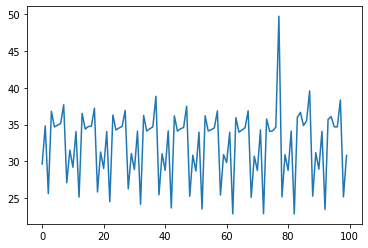

In [104]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [105]:
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

In [106]:
celeb_a_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.Normalize(0, 1),
])
celeb_a = ImageFolder('../data/celeb_a/', transform=celeb_a_transforms)

In [107]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

celeb_a_iter = iter(DataLoader(celeb_a))


torch.Size([1, 3, 256, 256])


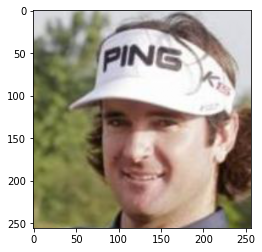

In [108]:
img, _ = next(celeb_a_iter)
print(img.size())
sing_img = img.squeeze()
plt.imshow(sing_img.permute(1, 2, 0))

In [109]:
# inference
import math
import torch

from generate import sample
from model import StyledGenerator

device = 'cpu'
ckpt_path = 'checkpoint/stylegan-256px-new.model'
resolution = 256
step = int(math.log(resolution, 2)) - 2

generator = StyledGenerator(512).to(device)
generator.load_state_dict(torch.load(ckpt_path)['g_running'])
generator.eval()
print(f"Succesfully loaded generator to {device}")

Succesfully loaded generator to cpu


In [110]:

# test if encoder is trained well
resnet34 = ResNetEncoder(layer_depths=[3, 4, 6, 3])
resnet34.load_state_dict(torch.load('resnet34-2.pt'))
resnet34.cpu()
resnet34.eval()
print(f"Succesfully loaded generator to {device}")


Succesfully loaded generator to cpu


In [130]:
with torch.no_grad():
    w = resnet34(img)
w[0, [1, 2, 3, 4]] = 0.1
w[0, [100,102,104,105]] = 1.0
w

tensor([[0.0000e+00, 1.0000e-01, 1.0000e-01, 1.0000e-01, 1.0000e-01, 0.0000e+00,
         0.0000e+00, 5.3293e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6459e-02,
         0.0000e+00, 7.8684e-02, 3.2154e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         3.4321e-02, 2.1238e-05, 3.8245e-05, 4.6687e-02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 9.7345e-02, 9.6541e-02, 0.0000e+00, 0.0000e+00, 1.2325e-01,
         0.0000e+00, 9.7492e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.2287e-02,
         1.6348e-02, 0.0000e+00, 4.0525e-02, 0.0000e+00, 0.0000e+00, 2.3022e-03,
         0.0000e+00, 4.5684e-03, 4.7353e-03, 0.0000e+00, 0.0000e+00, 2.7771e-02,
         0.0000e+00, 0.0000e+00, 2.6115e-02, 0.0000e+00, 0.0000e+00, 2.4475e-03,
         7.8854e-02, 5.3896e-02, 1.7648e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e

In [129]:
styles, image =sample(generator, step, None, 1, device, styles=[w])
styles[0]

tensor([[0.0000e+00, 1.0000e-01, 1.0000e-01, 1.0000e-01, 1.0000e-01, 0.0000e+00,
         0.0000e+00, 5.3293e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6459e-02,
         0.0000e+00, 7.8684e-02, 3.2154e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         3.4321e-02, 2.1238e-05, 3.8245e-05, 4.6687e-02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 9.7345e-02, 9.6541e-02, 0.0000e+00, 0.0000e+00, 1.2325e-01,
         0.0000e+00, 9.7492e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.2287e-02,
         1.6348e-02, 0.0000e+00, 4.0525e-02, 0.0000e+00, 0.0000e+00, 2.3022e-03,
         0.0000e+00, 4.5684e-03, 4.7353e-03, 0.0000e+00, 0.0000e+00, 2.7771e-02,
         0.0000e+00, 0.0000e+00, 2.6115e-02, 0.0000e+00, 0.0000e+00, 2.4475e-03,
         7.8854e-02, 5.3896e-02, 1.7648e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e

In [127]:
device

generator = StyledGenerator(512).to(device)
generator.load_state_dict(torch.load(ckpt_path)['g_running'])
generator.eval()
print(f"Succesfully loaded generator to {device}")

_, generated_img =sample(generator, step, None, 1, device, styles=[torch.zeros(1,512)])

Succesfully loaded generator to cpu


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 256, 256])


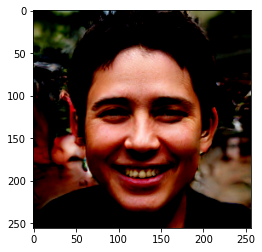

In [128]:
print(generated_img.size())
sing_img = generated_img.squeeze()
plt.imshow(sing_img.permute(1, 2, 0))